# On Analyzing Real World Time Series for Forecasting: Bitcoin Price Dataset (2017-2023)

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

# from collections import namedtuple
from data_loader import build_bitcoin_uts

from ts_models import RandomWalk, AR, ARMA, ARIMA_model, EvaluationMetric
# from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Differenced Data
10. Plot Autocorrelation and Partial Autocorrelation of Differenced Data
11. Initialize & Predict Random Walk `RW` Model on Raw Data
    1. Split Differenced Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
reversed_bitcoin_ts = build_bitcoin_uts()

In [3]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


In [4]:
bitcoin_ts = reversed_bitcoin_ts.data_augment_reverse()
bitcoin_ts

UnivariateTimeSeries(close)

In [5]:
bitcoin_df = bitcoin_ts.get_as_df()
bitcoin_df

,close
Timestamp,
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


### Difference

In [6]:
differenced_bitcoin_ts = bitcoin_ts.data_augment_with_differencing(1)
differenced_bitcoin_ts

UnivariateTimeSeries(Order-1 Difference of close)

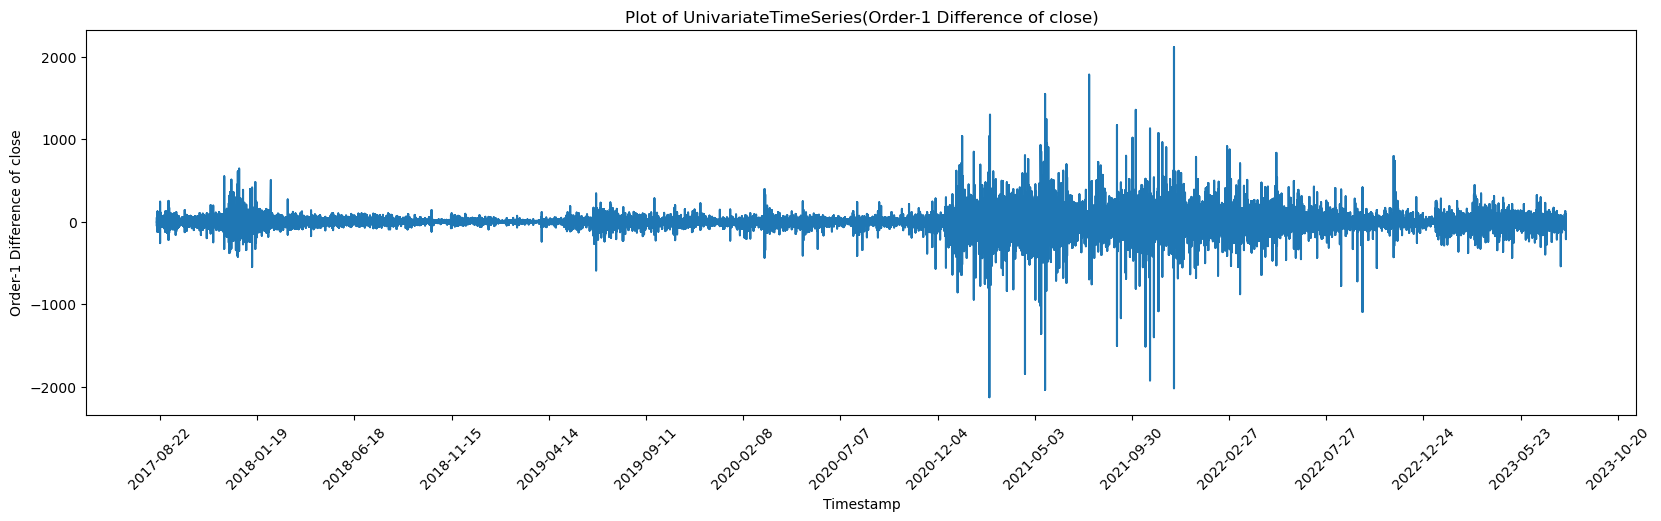

In [7]:
differenced_bitcoin_ts.plot(tick_skip=150)

- Data is differenced once. Will difference again to see plot and choose which is best as stationarity and independence test are taking a while on the raw data and assuming it'll take the same time on the differences as it's the same length. 

In [8]:
# differenced_2_bitcoin_ts = bitcoin_ts.data_augment_with_differencing(2)
# differenced_2_bitcoin_ts.plot(tick_skip=150)

- Too much differencing or code for 2nd diff and after is wrong? Will go with difference 1. 

### Get Descriptive Statistics of Differenced Data

In [9]:
differenced_bitcoin_ts.get_statistics()

,Order-1 Difference of close
count,3.125999e+06
mean,7.882603e-03
std,2.862586e+01
min,-2.129570e+03
25%,-5.180000e+00
50%,0.000000e+00
75%,5.160000e+00
max,2.115780e+03


In [10]:
differenced_bitcoin_ts.range_skewness_kurtosis()

{'Range': Order-1 Difference of close    4245.35
 dtype: float64,
 'Skewness': Order-1 Difference of close   -0.35713
 dtype: float64,
 'Kurtosis': Order-1 Difference of close    154.179352
 dtype: float64}

### Check Stationarity of Difference Data

In [11]:
# differenced_bitcoin_df = differenced_bitcoin_ts.get_as_df()
# differenced_bitcoin_ts.stationarity_test(differenced_bitcoin_df)

- Taking a while on the raw data and assuming it'll take the same time on the differenced data

### Plot Autocorrelation and Partial Autocorrelation of Difference Data

In [12]:
# differenced_bitcoin_ts.plot_autocorrelation(30)

- Exponentially dies out at lag 1, so no correlation between $ z_0 $  and $ z_1 $. With this, there doesn't exists any correlation between $ z_0 $ and the remaining $ z_{t - 1} $.
- Takes a while on entire dataset. Can run, have it print for first 30 or k lags, stop cell from running, and continue.

In [13]:
# differenced_bitcoin_ts.plot_partial_autocorrelation(35)

### Initialize AR(p) and ARMA(p, q) Models
- How to determine the proper lag p value? Look at the Partial ACor plot. Assumption: Being that we're out of the blue area at lag 1, we'll set our lag to be 1. Assuming because it takes a while to run PACor plot on entire dataset. 

- How to determine the proper error q value? Look at the ACor plot. Assumption: Being that we're out of the blue area at lag 1, we'll set our error to be 1. Assuming because it takes a while to run ACor plot on entire dataset. 

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Differences Data

#### Split Differenced Data
- Forecast for the entirety of the next day. Observations are currently in minutes, so would need 1440 as forecasting step (60 mins = 1 hr and 24 hrs in a day, so 60 * 24).
- Forecast for the entirety of the next year. (365 days = 1 hr and 24 hrs in a day, so 60 * 24 * 365)

In [14]:
diff_bitcoin_series = differenced_bitcoin_ts.get_series()
len(diff_bitcoin_series), diff_bitcoin_series

(3125999, array([  0.  ,  19.08, -19.08, ...,  -6.04,   0.  ,   0.  ]))

In [15]:
day_forecast = 60 * 24
year_forecast = day_forecast * 365
forecasting_step = year_forecast
diff_N = len(diff_bitcoin_series)
diff_train_length = diff_N - forecasting_step
diff_train_length

2600399

In [16]:
diff_train_uts, diff_test_uts = differenced_bitcoin_ts.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

1 2600399


(UnivariateTimeSeries(UnivariateTimeSeries(Order-1 Difference of close)[1:2600399]),
 UnivariateTimeSeries(UnivariateTimeSeries(Order-1 Difference of close)[2600399:3125999]))

In [17]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

,UnivariateTimeSeries(Order-1 Difference of close)[1:2600399]
Timestamp,
2017-08-17,19.08
2017-08-17,-19.08
2017-08-17,0.00
2017-08-17,0.00
2017-08-17,0.00
...,...
2022-08-01,7.67
2022-08-01,5.47
2022-08-01,9.82


In [18]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

,UnivariateTimeSeries(Order-1 Difference of close)[2600399:3125999]
Timestamp,
2022-08-01,-2.12
2022-08-01,-26.93
2022-08-01,21.22
2022-08-01,-49.23
2022-08-01,-13.02
...,...
2023-08-01,11.42
2023-08-01,1.12
2023-08-01,-6.04


In [19]:
lag_p = 1
ar_model_class = AR()
ar_model = ar_model_class.train_ar_model(diff_train_df, lag_p)

error_q = 1
arma_model_class = ARMA()
arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date in

In [20]:
# retrain false
ar_predictions_no_retrain = ar_model_class.predict(ar_model, diff_train_df, diff_test_df, False, lag_p)

# # retrain true
ar_predictions_retrain = ar_model_class.predict(ar_model, diff_train_df, diff_test_df, True, lag_p)

# retrain false
arma_predictions_no_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, False, lag_p)

# retrain true
arma_predictions_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, True, lag_p)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
# arma_predictions_no_retrain

In [22]:
# arma_predictions_retrain

In [23]:
# len(diff_test_df), len(ar_predictions_no_retrain), len(ar_predictions_retrain)
# len(diff_test_df), len(arma_predictions_no_retrain), len(arma_predictions_retrain)

In [24]:
ar_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, ar_predictions_no_retrain, per_element=False)
ar_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_no_retrain, per_element=False)

ar_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, ar_predictions_retrain, per_element=False)
ar_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_retrain, per_element=False)

arma_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
arma_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)

arma_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
arma_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

Test MSE: 234.540
Test RMSE: 15.315
Test MSE: 234.554
Test RMSE: 15.315
Test MSE: 234.540
Test RMSE: 15.315
Test MSE: 296.645
Test RMSE: 17.223


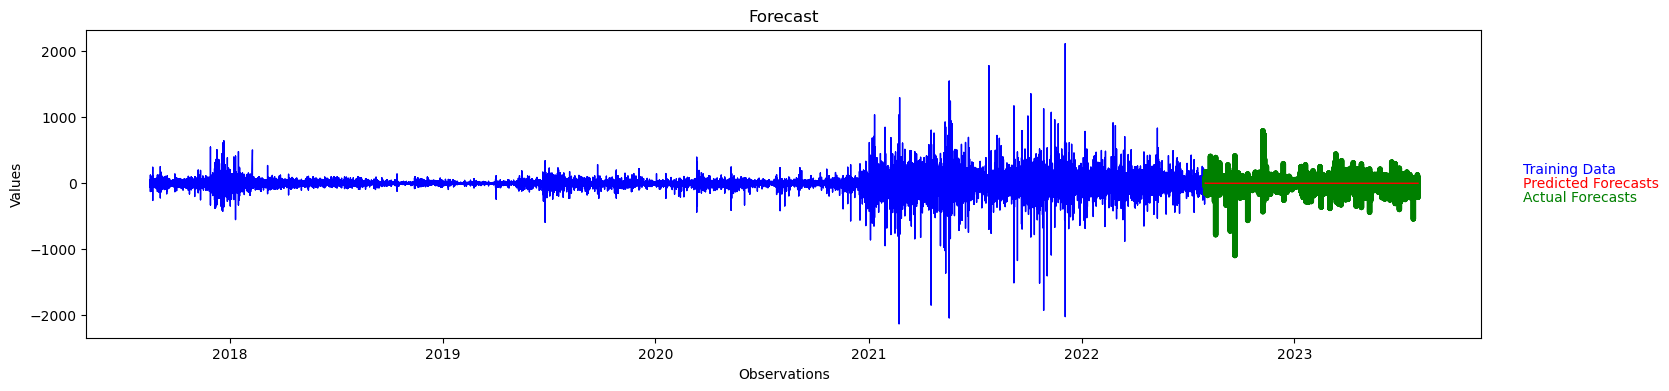

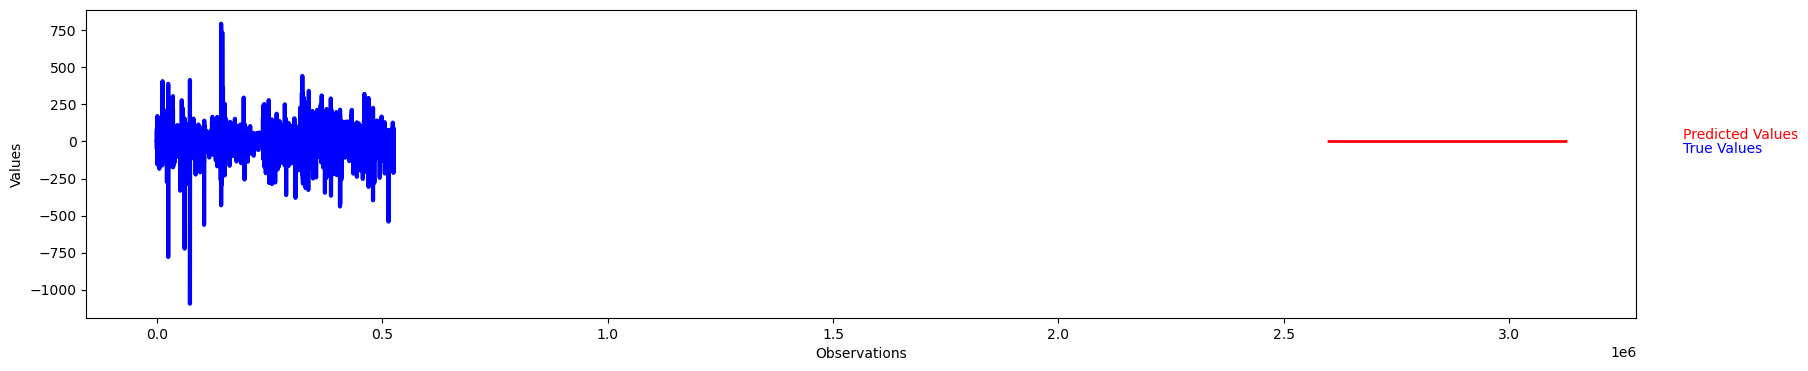

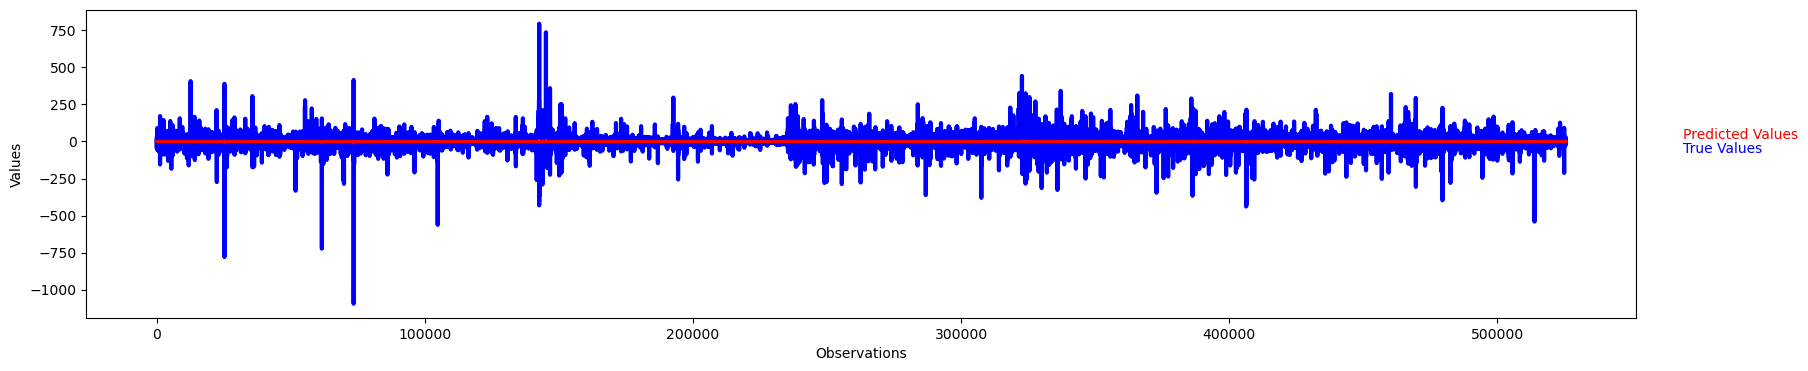

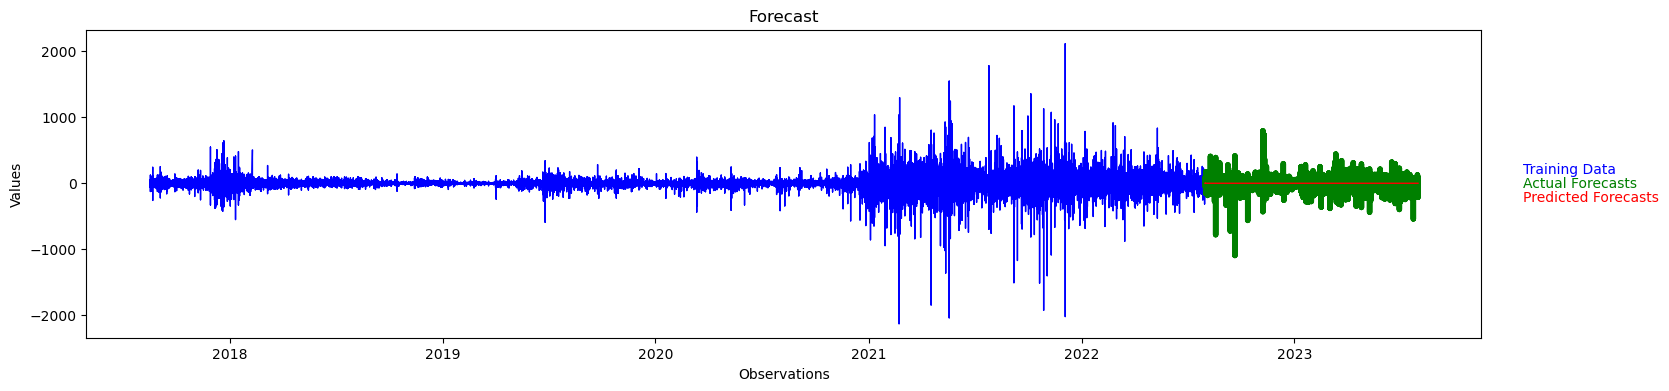

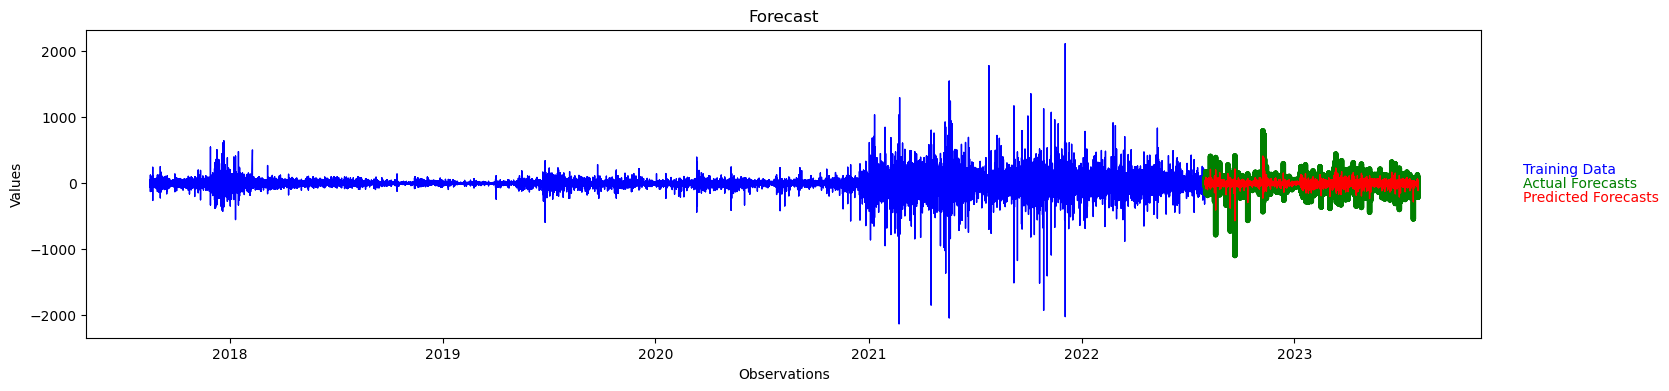

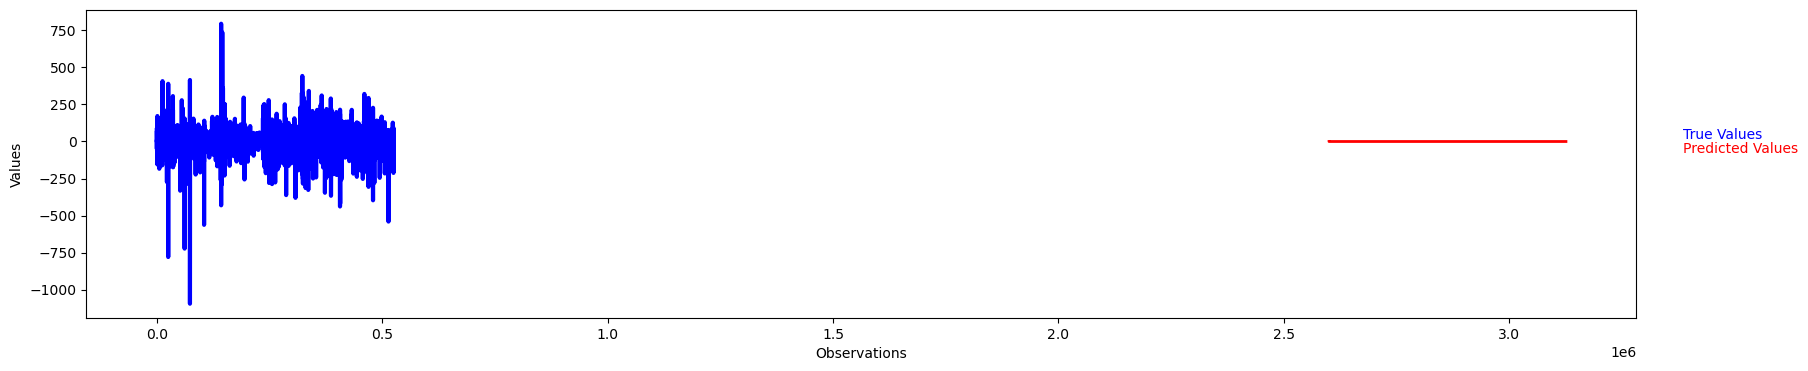

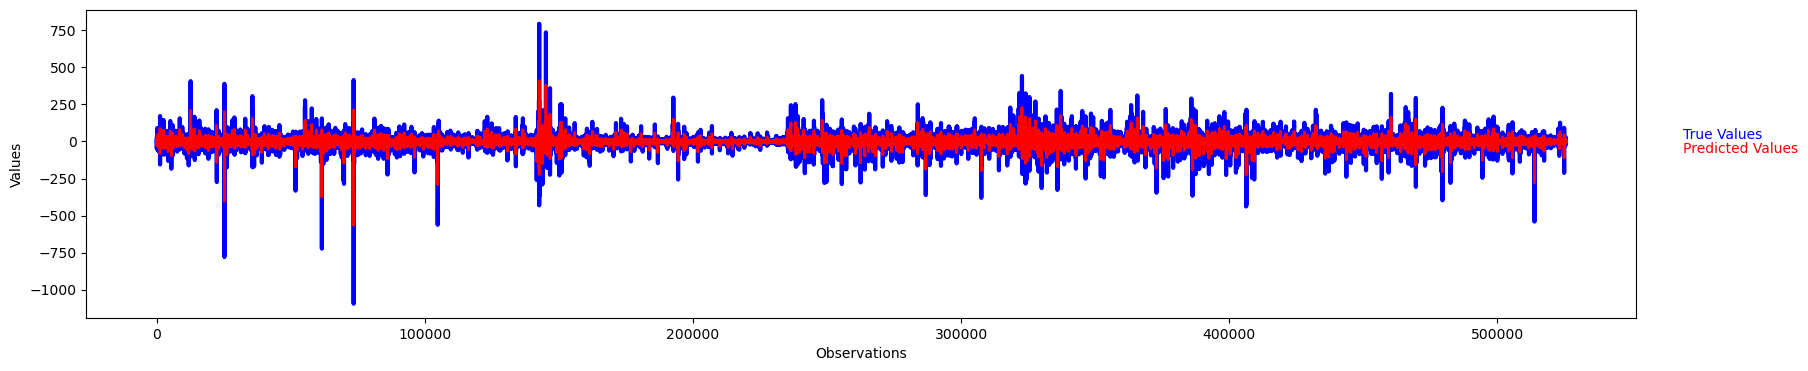

In [25]:
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, ar_predictions_no_retrain, False)
EvaluationMetric.plot_predictions(diff_test_df, ar_predictions_no_retrain)
EvaluationMetric.plot_predictions(diff_test_df, ar_predictions_retrain)


EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_no_retrain, False)
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_retrain, False)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_no_retrain)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_retrain)

### Follow-up
- What can we determine from this?
    - Differenced TS
        - `ARMA-no-retrain`
        - `ARMA-retrain`
        - `ARIMA-no-retrain`
        - `ARIMA-retrain` 